## The Sliding Window

A Convolutional Neural Network built for image recognition has what is known as a window. This window is defined by the kernel, and looks at multiple pixels at a time. This window can slide in different ways, either moving by a PAD or a STRIDE. PAD movement attempts to move one pixel at a time, covering exactly enough to read the entire image.

For example: If the image is a 5x5 and the kernel is a 3x3, the window will start at (1,1) instead of (0,0) and proceed until (1,3) then back to (2,1) until eventually ending at (3,3). Thus ignoring the outermost pixels in the image, as it will see them all by going over the inner section.

For STRIDE type movement, a horizontal and vertical stride tuple is defined for the number of pixels to move by in each step. Any values over 1 will cause the window to skip over pixels. With a 3x3 kernel and a stride tuple of (2,2), the window will see every pixel in the image with relatively minimal redundancy.

In [2]:
# Imports and setup
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings = True

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

Exercise 4 can not be translated away from the course, so moving on to 5

## Building a complete model

Now we can put everything we've learned together to build a model without any pre-training

In [3]:
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
from matplotlib import gridspec

# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    'train/',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    'valid/',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


In [4]:
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (ds_train_.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE))
ds_valid = (ds_valid_.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE))


## Design a Convnet

Now we design the convolutional network. The goal, once again, is to identify cars vs trucks with similar accuracy to the pre-trained VGG16 model in the previous exercise. To achieve this we can try making a network with several layers combining pooling and 2D Convolution, and end with a normal ReLU network

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential()

# first block
model.add(layers.Conv2D(filters=32, kernel_size=3, activation='relu',
                        padding='same', input_shape=[128,128,3]))
model.add(layers.MaxPool2D())

# second block
model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(layers.MaxPool2D())

# third block
model.add(layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(layers.MaxPool2D())

# fourth block
model.add(layers.Flatten())
model.add(layers.Dense(units=6, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=1, activation='sigmoid'))


In [7]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(epsilon=0.1),
               loss='binary_crossentropy',
               metrics = ['binary_accuracy'])

Running the model will take about 110 minutes

In [8]:
# run the model
history = model.fit(ds_train, 
                    validation_data = ds_valid, 
                    epochs=50, 
                    verbose=0)

<Axes: >

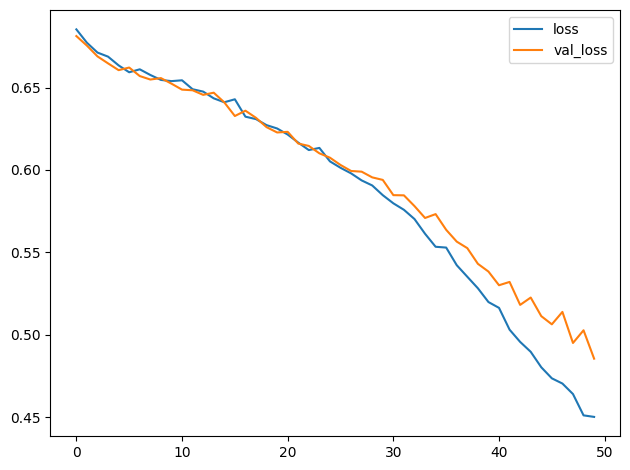

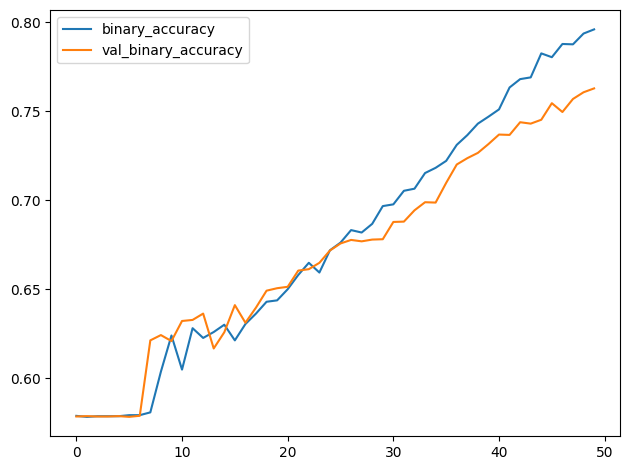

In [9]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:,['loss','val_loss']].plot()
history_frame.loc[:,['binary_accuracy','val_binary_accuracy']].plot()

This model appears to be underfitting, as both the loss and val loss are fairly high. This model would likely be a decent fit if it was given more time to train, but we can improve it in other ways instead to save on time.